# Explaining Model Predictions with LIME

In [1]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical


tf.__version__

'2.12.0'

In [2]:
# Custom functions:
%load_ext autoreload
%autoreload 2
# sys.path.append(os.path.abspath("../../"))
import custom_functions as cf
help(cf)


Help on package custom_functions:

NAME
    custom_functions

PACKAGE CONTENTS
    ann_functions
    capture_output
    fileinfo
    model_logging
    quantize_model
    utils

SUBMODULES
    capture
    logs
    quantize

FUNCTIONS
    show_code(function)
        Uses the inspect module to retrieve the source code for a function.
        Displays the code as Python-syntax Markdown code.
        
        Note: Python highlighting may not work correctly on some editors.
        
        Parameters:
        function (callable): The function for which to display the source code.
        
        Returns:
        None

FILE
    /Users/codingdojo/Documents/GitHub/_MY_PROJECTS/computer-vision-american-sign-language/custom_functions/__init__.py




In [3]:
# New import for explanations
from skimage.segmentation import mark_boundaries
from lime import lime_image


In [4]:

import json, os
from pprint import pprint

# Define filename for project config filepaths jso?n file
FPATHS_FILE = "config/filepaths.json"

## Save the filepaths
with open(FPATHS_FILE, "r") as f:
    FPATHS = json.load(f)
    print(f"\n[i] Loaded FPATHS from {FPATHS_FILE}")
FPATHS.keys()


[i] Loaded FPATHS from config/filepaths.json


dict_keys(['data', 'images', 'eda', 'modeling', 'readme'])

In [5]:
FPATHS['images']

{'banner': 'images/American_Sign_Language_ASL.svg',
 'alphabet': 'images/Sign_language_alphabet_(58).png',
 'lime-correct_png': 'images/lime-explain-correct.png',
 'lime-correct_md': 'images/lime-explain-correct.md',
 'lime-incorrect_png': 'images/image-explain-incorrect.png',
 'lime-incorrect_md': 'images/lime-explain-incorrect.md',
 'lime-incorrect-bad-image_png': 'images/lime-explain-incorrect-bad-img.png',
 'lime-incorrect-bad-image_md': 'images/lime-explain-incorrect-bad-img.md'}

In [6]:
FPATHS['readme']

{'results_table_md': 'modeling/results_table.md',
 'Part01-intro_md': 'config/readme_part1_intro.md',
 'Part02-model': 'config/readme_part2_results.md',
 'Part03-explain': 'config/readme_part3_lime_explanations.md',
 'Part04-conclusion': 'config/readme_part4_conclusion.md'}

In [7]:
# Load params used
PARAMS_FILE = FPATHS['modeling']['params']

with open(PARAMS_FILE, "r") as f:
    PARAMS = json.load(f)
    print(f"\n[i] Loaded params from {PARAMS_FILE}")
PARAMS


[i] Loaded params from modeling/params.json


{'BATCH_SIZE': 32,
 'IMG_HEIGHT': 128,
 'IMG_WIDTH': 128,
 'TRAIN_SPLIT': 0.7,
 'VAL_SPLIT': 0.15,
 'PATIENCE': 5,
 'RESTORE_BEST_WEIGHTS': True,
 'EPOCHS': 100}

In [8]:
import json
FPATHS['modeling']


{'model_dir': 'modeling/models/',
 'results_log': 'modeling/nn_training.log',
 'results_log_csv': 'modeling/nn_training.csv',
 'train-dataset_dir': 'modeling/data/training-data-tf/',
 'val-dataset_dir': 'modeling/data/validation-data-tf/',
 'test-dataset_dir': 'modeling/data/testing-data-tf/',
 'params': 'modeling/params.json',
 'label-lookup_json': 'modeling/label_lookup.json'}

In [9]:
train_dataset = tf.data.Dataset.load(FPATHS['modeling']['train-dataset_dir'],
                                    compression="GZIP")
val_dataset = tf.data.Dataset.load(FPATHS['modeling']['val-dataset_dir'],
                                  compression="GZIP")
test_dataset = tf.data.Dataset.load(FPATHS['modeling']['test-dataset_dir'],
                                   compression="GZIP")
import json
with open(FPATHS['modeling']['label-lookup_json']) as f:
    label_lookup = json.load(f)

label_lookup = {int(k):v for k,v in label_lookup.items()}
reverse_label_lookup = {v:k for k,v in label_lookup.items()}
print(label_lookup)

Metal device set to: Apple M1 Pro
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [10]:
# loaded_train = tf.data.Dataset.load(FPATHS['modeling']['train-dataset_dir'], compression='GZIP')#, reader_func=load_image)

Test batch - images: (32, 128, 128, 3), labels: (32, 26)
Label=C


2024-06-05 19:33:19.489469: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


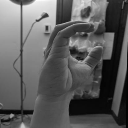

In [11]:
i= 0 
for images, labels in train_dataset.take(1):
    print(f"Test batch - images: {images.shape}, labels: {labels.shape}")
    print(f'Label={label_lookup[ np.argmax(labels[i])]}')
    display(array_to_img(images[i]))

In [12]:
## Load model logs
logs_df = cf.logs.parse_log_file(FPATHS['modeling']['results_log'])


logs_df['Start Time'] = pd.to_datetime(logs_df['Start Time'])
logs_df = logs_df.set_index("Start Time")
logs_df = logs_df.sort_index(ascending=False)
logs_df


[i] Saved parsed logs to modeling/nn_training.csv


,Name,Precision,Recall,F1-Score,Accuracy,Fit Time,Model Save Fpath
Start Time,,,,,,,
2024-06-05 16:39:27,EfficientNetB0-1,0.747,0.733,0.715,0.732,0:01:24.104776,modeling/models/EfficientNetB0-1
2024-06-05 16:37:56,VGG16-01,0.654,0.612,0.599,0.614,0:01:19.377717,modeling/models/VGG16-01
2024-06-05 16:37:30,cnn1-scheduled-lr,0.002,0.038,0.003,0.039,0:00:19.401393,modeling/models/cnn1-scheduled-lr
2024-06-05 16:36:57,cnn1-fixed-lr,0.499,0.471,0.456,0.482,0:00:27.681576,modeling/models/cnn1-fixed-lr
2024-06-05 16:35:35,towards-data-science-blog,0.488,0.444,0.433,0.452,0:01:14.607511,modeling/models/towards-data-science-blog


In [13]:

logs_df.duplicated(keep=False, subset=['Model Save Fpath'])

Start Time
2024-06-05 16:39:27    False
2024-06-05 16:37:56    False
2024-06-05 16:37:30    False
2024-06-05 16:36:57    False
2024-06-05 16:35:35    False
dtype: bool

In [14]:
best_model_fpath = logs_df.set_index("Model Save Fpath")['F1-Score'].idxmax()
best_model_fpath

'modeling/models/EfficientNetB0-1'

dict_keys(['classification_report', 'history_fig', 'confusion_matrix_fig', 'model'])

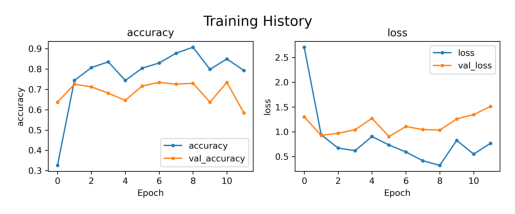

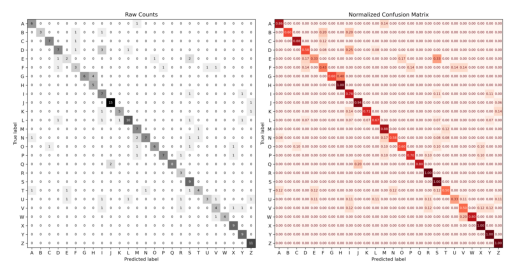

In [15]:
loaded_results = cf.logs.load_model_results(model_fpath=best_model_fpath, load_model=True)
loaded_results.keys()

In [16]:
BEST_MODEL = loaded_results['model']
BEST_MODEL.summary()

Model: "EfficientNetB0-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input_enet (Lamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 20480)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               5243136   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 26)           


- Evaluating Network...

- Evaluating Test Data:
8/8 [==============================] - 4s 219ms/step - loss: 0.9380 - accuracy: 0.7325
{'loss': 0.937951385974884, 'accuracy': 0.7324561476707458} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.75      0.86      0.80         7
           B       1.00      0.60      0.75         5
           C       0.88      0.88      0.88         8
           D       0.70      0.58      0.64        12
           E       0.50      0.33      0.40         6
           F       0.50      0.43      0.46         7
           G       1.00      0.60      0.75        10
           H       0.56      1.00      0.71         5
           I       0.47      0.78      0.58         9
           J       0.88      0.94      0.91        16
        

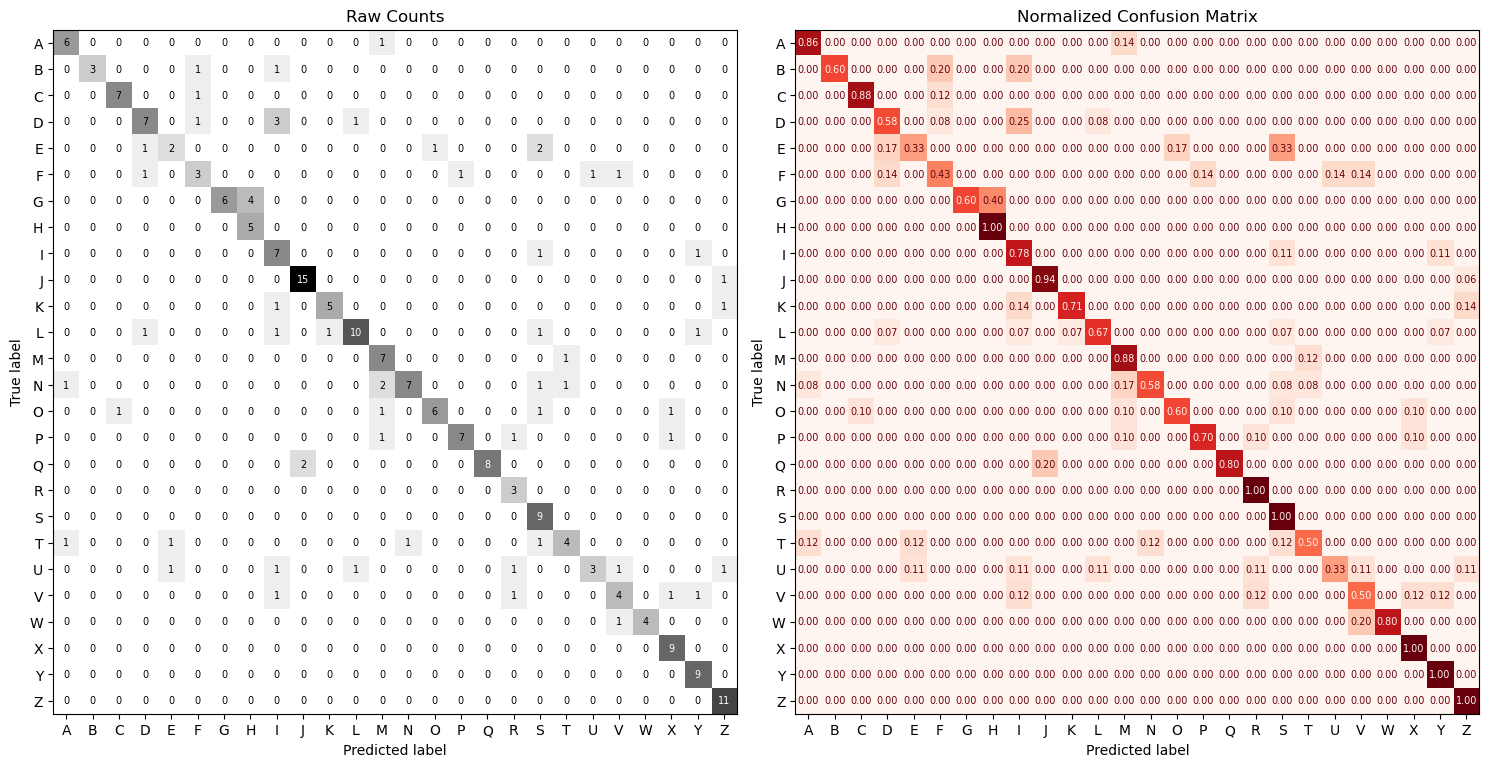

dict_keys(['results-classes', 'results-overall'])

In [17]:
# Evaluate saved model 
results, figs = cf.custom_evaluate_classification_network(BEST_MODEL,test_dataset,
                                                          target_names=label_lookup.values(),
                                                         frame_include_support=True)
results['test'].keys()

In [18]:
sort_by = 'f1-score'
class_results = results['test']['results-classes']
class_results.sort_values(by=sort_by).style.bar(subset=[sort_by])

,precision,recall,f1-score,support
E,0.500000,0.333333,0.400000,6
F,0.500000,0.428571,0.461538,7
U,0.750000,0.333333,0.461538,9
V,0.571429,0.500000,0.533333,8
T,0.666667,0.500000,0.571429,8
I,0.466667,0.777778,0.583333,9
D,0.700000,0.583333,0.636364,12
R,0.500000,1.000000,0.666667,3
N,0.875000,0.583333,0.700000,12
M,0.583333,0.875000,0.700000,8


## Extract Images and Predictions as Numpy Arrays

- Data needs to be in numpy arrays for LIME. The true labels and images need to be extracted batchwise while getting predictions from the model.

In [19]:
%%time
# timing WITH converting classes
y_test, y_hat_test, X_test = cf.get_true_pred_labels_images(BEST_MODEL,
                                                            test_dataset,
                                                            convert_y_for_sklearn=True)
y_test[0], y_hat_test[0]

CPU times: user 4.62 s, sys: 689 ms, total: 5.31 s
Wall time: 4.36 s


(3, 8)

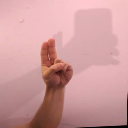

True Label: U
Predicted: Z


In [20]:
## Demonstrating numpy array version of data
# select an image index to use/view
i = 8

# Show actual-sized image with keras
display(array_to_img(X_test[i]))
print(f"True Label: {label_lookup[y_test[i]]}")
print(f"Predicted: {label_lookup[y_hat_test[i]]}")

In [21]:
y_test, y_hat_test

(array([ 3, 19, 16, 21, 15, 12, 23,  2, 20,  8, 10, 18, 21,  9, 12, 19, 24,
        14, 19,  9, 25, 12,  1,  3, 21, 16, 15, 14, 20,  6,  2, 11,  4, 17,
         6,  6,  5, 20, 13, 11, 18, 23, 25, 14, 10,  1, 19,  0, 22, 22, 16,
        11, 14, 16, 25, 25, 11, 19, 15,  4, 22, 11, 13, 24,  9,  5, 16, 25,
         9, 11, 16,  3,  9,  0,  3,  8,  8, 13,  8, 18, 12, 11, 25, 25, 16,
        25, 11, 24, 20,  9, 10, 23,  5,  3,  9, 17,  2, 24, 21, 11, 13,  1,
        15, 18, 15, 20,  4, 13,  5, 10,  9, 19,  6, 13, 18, 20, 15, 15, 18,
        12, 20, 21,  1,  5,  4, 14, 20, 13, 13,  7, 13,  9,  2, 23, 24, 13,
         3, 16, 14, 15, 16,  6,  8, 25,  2, 14,  7, 20, 25,  3, 23, 24, 22,
        13,  6, 18, 21, 24,  0,  9, 10,  9, 11,  8, 23,  6,  9,  7, 21,  2,
        13,  1,  3, 10,  0, 12, 18,  3, 10,  8, 24, 24,  4, 25, 12, 19,  8,
        17, 21, 14,  7, 11,  9,  0,  9,  6, 23, 14,  2,  8,  6,  2,  0,  3,
        11,  5,  5,  9,  9, 12, 14,  3,  4, 19,  3, 16, 18, 15,  6, 23, 11,
        11, 

In [22]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, y_hat_test, output_dict=True, target_names=label_lookup.values())

# Remove overall stats from dict
pop_stats = ['accuracy','macro avg','weighted avg']
for key in pop_stats:
    if key in report_dict:
        report_dict.pop(key)

## Convert class results to transposed dataframe
report_df =  pd.DataFrame(report_dict).T.round(2)
report_df

,precision,recall,f1-score,support
A,0.75,0.86,0.80,7.0
B,1.00,0.60,0.75,5.0
C,0.88,0.88,0.88,8.0
D,0.70,0.58,0.64,12.0
E,0.50,0.33,0.40,6.0
F,0.50,0.43,0.46,7.0
G,1.00,0.60,0.75,10.0
H,0.56,1.00,0.71,5.0
I,0.47,0.78,0.58,9.0
J,0.88,0.94,0.91,16.0


# Explaining Model Predictions with Lime

## Filtering For Correct/Incorrect Predictions

In [23]:
# Confirming manual calculation of accuracy matches report
idx_correct=  y_test == y_hat_test
idx_correct.sum() / len(idx_correct)

0.7324561403508771

In [24]:
# Filter for correctly classified images
X_test_correct = X_test[idx_correct]
y_test_correct = y_test[idx_correct]
y_hat_test_correct = y_hat_test[idx_correct]

print(f"{X_test_correct.shape=}", f"{y_test_correct.shape=}", f"{y_hat_test_correct.shape=}",sep = "\n")

X_test_correct.shape=(167, 128, 128, 3)
y_test_correct.shape=(167,)
y_hat_test_correct.shape=(167,)


In [25]:
# Filter for incorrectly classified images
X_test_incorrect = X_test[~idx_correct]
y_test_incorrect = y_test[~idx_correct]
y_hat_test_incorrect = y_hat_test[~idx_correct]

print(f"{X_test_incorrect.shape=}", f"{y_test_incorrect.shape=}", f"{y_hat_test_incorrect.shape=}",sep = "\n")

X_test_incorrect.shape=(61, 128, 128, 3)
y_test_incorrect.shape=(61,)
y_hat_test_incorrect.shape=(61,)


## Explaining a Correctly Classified Image

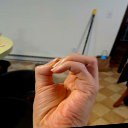

True Label: O
Predicted: O


In [26]:
# select an image index to use/view
i = 87

# Show actual-sized image with keras
display(array_to_img(X_test_correct[i]))
print(f"True Label: {label_lookup[y_test_correct[i]]}")
print(f"Predicted: {label_lookup[y_hat_test_correct[i]]}")

In [27]:
explainer = lime_image.LimeImageExplainer(verbose=True,random_state=321)
explainer

In [28]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test_correct[i], # Convert image values to ints    
                                         BEST_MODEL.predict, # Prediction method/function
                                         top_labels=2, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
Intercept -0.017542458715927106
Prediction_local [0.03167999]
Right: 0.14169921
Intercept -0.1365478247674054
Prediction_local [0.26415481]
Right: 0.6111957


In [29]:
# Lime returns the top 2 labels for the example
top_labels = [label_lookup[k] for k in  explanation.top_labels]
top_labels

['O', 'F']

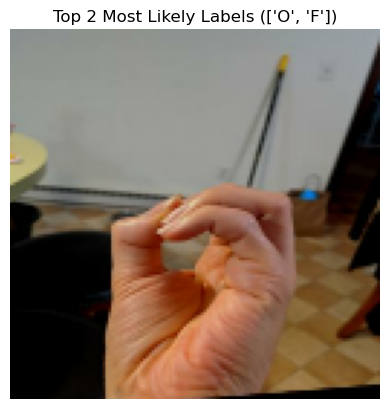

In [30]:
# Stored original image
top_labels = [label_lookup[k] for k in  explanation.top_labels]

fig, ax = plt.subplots()
ax.imshow(explanation.image.astype(int));
ax.axis('off');
ax.set_title(f"Top 2 Most Likely Labels ({top_labels})");


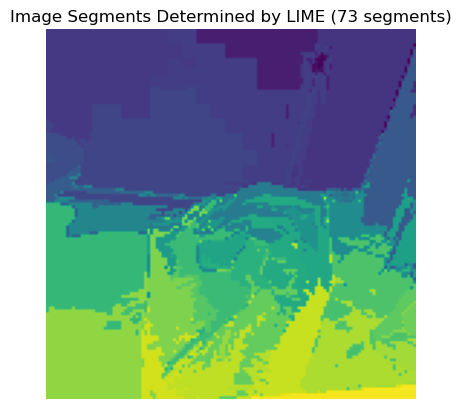

In [31]:
# Explanation split image into "segments"
# Stored original image
fig, ax = plt.subplots()
ax.imshow(explanation.segments); 
ax.axis('off');

# Unique Segments
n_segments = len(np.unique(explanation.segments))
ax.set_title(f'Image Segments Determined by LIME ({n_segments} segments)');

> First, let's examine the areas of the image that were promoting the model to predict the top label.

In [32]:
rgb_red =(1.,0.,0.)
rgb_green = (0., 1.,0.)

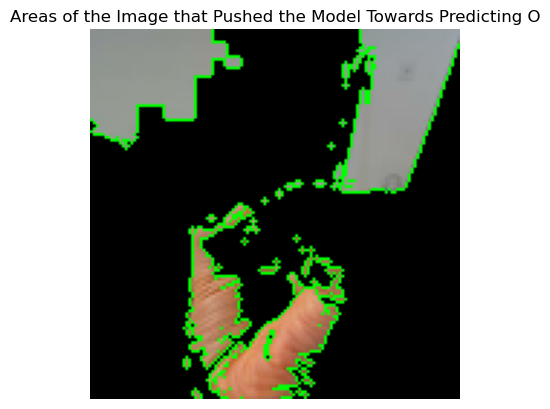

In [33]:
# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    # num_features=10,
    hide_rest=True
)

# Display the original image with the explanation
fig, ax=  plt.subplots()
ax.imshow(mark_boundaries(temp / 255.0, mask, color=rgb_green))
ax.axis('off')
ax.set_title(f"Areas of the Image that Pushed the Model Towards Predicting {top_labels[0]}");

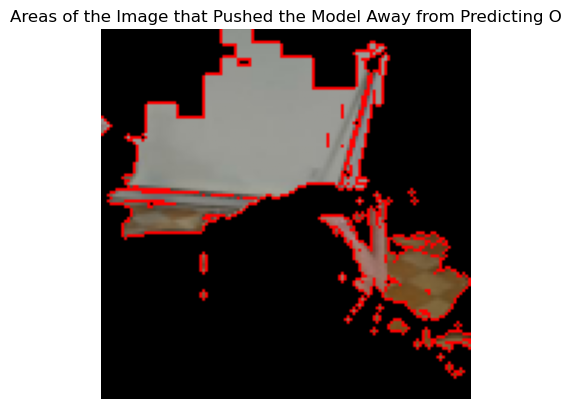

In [34]:
# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    # num_features=10,
    hide_rest=True
)

# Display the original image with the explanation
fig, ax=  plt.subplots()
ax.imshow(mark_boundaries(temp / 255.0, mask, color=rgb_red))
ax.axis('off')
ax.set_title(f"Areas of the Image that Pushed the Model Away from Predicting {top_labels[0]}");

In [35]:
i_correct = 87
i_correct

87

In [36]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from IPython.display import clear_output

def plot_comparison(BEST_MODEL, X_test, y_test, i,label_lookup, suptitle="LIME Explanation", 
                    suptitle_y=1.02, suptitle_fontsize='xx-large'):
    """Adapted from Source:
    https://coderzcolumn.com/tutorials/artificial-intelligence/lime-explain-keras-image-classification-network-predictions"""
    rgb_red =(1.,0.,0.)
    rgb_green = (0., 1.,0.)
    # Instantaite lime explainer
    explainer = lime_image.LimeImageExplainer(verbose=0,random_state=321)
    

    # Get the explanation object for the chosen
    with cf.capture.capture_output():
        explanation = explainer.explain_instance(X_test[i], # Convert image values to ints    
                                             BEST_MODEL.predict, # Prediction method/function
                                             top_labels=2, # How many of the labels to explain [?]
                                             hide_color=0, #
                                             num_samples=1000,
                                                 
                                            )
    # Plot results
    fig,axes = plt.subplots(ncols=4,figsize=(15,5))
    axes = axes.flatten()

    # Stored original image
    ax = axes[0]
    top_labels = [label_lookup[k] for k in  explanation.top_labels]
    ax.imshow(explanation.image.astype(int));
    ax.axis('off');
    ax.set_title(f"Top 2 Most Likely Labels({top_labels})\nTrue Label={label_lookup[y_test[i]]}");

    # Segments analyzed by LIME
    ax = axes[1]
    ax.imshow(explanation.segments); 
    ax.axis('off');
    
    n_segments = len(np.unique(explanation.segments))
    ax.set_title(f'Image Segments\n({n_segments} segments)');
    

    ## Segments that pushed pred towards top_label
    ax = axes[2]
    # Get the explanation for the top label
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        # num_features=10,
        hide_rest=True)
    
    # Display the original image with the explanation
    ax.imshow(mark_boundaries(temp / 255.0, mask, color=rgb_green))
    ax.axis('off')
    ax.set_title(f"Segments that Pushed the Model \nTowards Predicting {top_labels[0]}");

    ## Segments that pushed pred away from top_label
    # Get the explanation for the top label (but negative_only)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        negative_only=True,
        # num_features=10,
        hide_rest=True
    )
    
    # Display the original image with the explanation
    ax=  axes[3]
    ax.imshow(mark_boundaries(temp / 255.0, mask, color=rgb_red))
    ax.axis('off')
    ax.set_title(f"Segments that Pushed the model\nAway from Predicting {top_labels[0]}");


    # 
    fig.tight_layout()
    fig.suptitle(suptitle, y=suptitle_y, fontsize=suptitle_fontsize)
    return fig

  0%|          | 0/1000 [00:00<?, ?it/s]

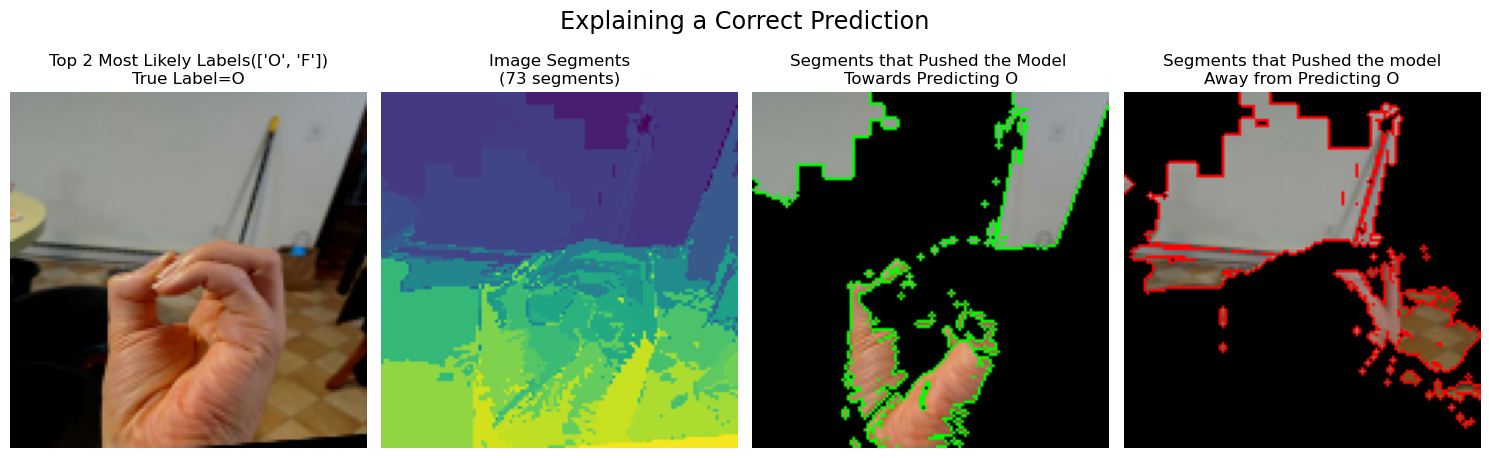

In [37]:
fig_fpath = FPATHS['images']['lime-correct_png']
md_fpath = FPATHS['images']['lime-correct_md']
fig = plot_comparison(BEST_MODEL, X_test_correct, y_test_correct, i_correct,
                      label_lookup, suptitle='Explaining a Correct Prediction', suptitle_fontsize='xx-large')

fig.savefig(fig_fpath, dpi=300, transparent=False, bbox_inches='tight')

In [38]:
from IPython.display import display, Markdown

explanation_correct = """#### LIME Explanation for Correctly Classified Image

[IMG]

Here we can see that the model was able to identify the letter O using the palm and thumb. The model used the crevice betwen the pinky and ring finges to differeniate between O and F.

The letters O and F in ASL are indeed similar, as both involve the fingers forming a loop. However, they have distinct differences that can be critical for accurate classification.


- Key Similarities:
    - Both letters involve forming a loop with the fingers.
    - Both have a circular shape as part of the sign.
- Key Differences:
    - In the letter O, all fingers and the thumb touch to form the circle, while in the letter F, only the thumb and index finger touch.
    - The remaining fingers in the letter F are extended, whereas in the letter O, they are curved and relaxed."""

# final_explanation_correct = f'<img src="{fig_fpath}">\n' + explanation_correct
final_explanation_correct = explanation_correct.replace("[IMG]", f'<img src="{fig_fpath}">')
with open(md_fpath,'w') as f:
    f.write(final_explanation_correct)

display(Markdown(final_explanation_correct))

#### LIME Explanation for Correctly Classified Image

<img src="images/lime-explain-correct.png">

Here we can see that the model was able to identify the letter O using the palm and thumb. The model used the crevice betwen the pinky and ring finges to differeniate between O and F.

The letters O and F in ASL are indeed similar, as both involve the fingers forming a loop. However, they have distinct differences that can be critical for accurate classification.


- Key Similarities:
    - Both letters involve forming a loop with the fingers.
    - Both have a circular shape as part of the sign.
- Key Differences:
    - In the letter O, all fingers and the thumb touch to form the circle, while in the letter F, only the thumb and index finger touch.
    - The remaining fingers in the letter F are extended, whereas in the letter O, they are curved and relaxed.

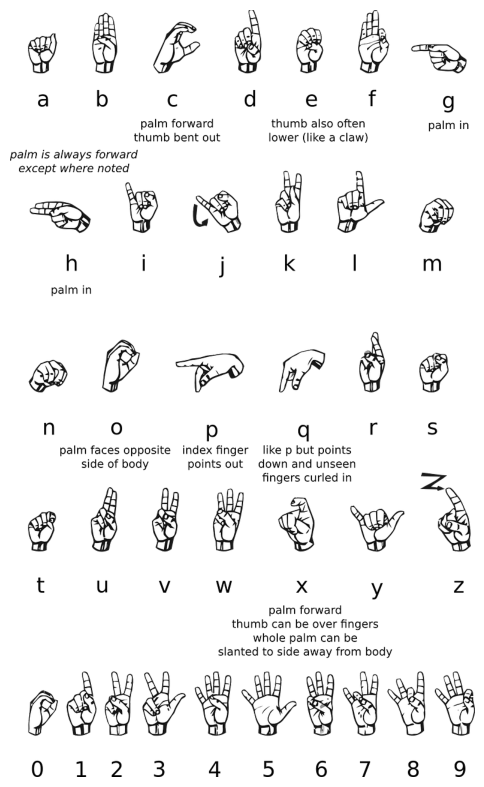

In [39]:
fig, ax=  plt.subplots(figsize=(6,12))
ax.imshow(plt.imread(FPATHS['images']['alphabet']))
ax.axis('off');

### Explain Incorrectly Classified Image

#### Incorrect - Image Quality

  0%|          | 0/1000 [00:00<?, ?it/s]

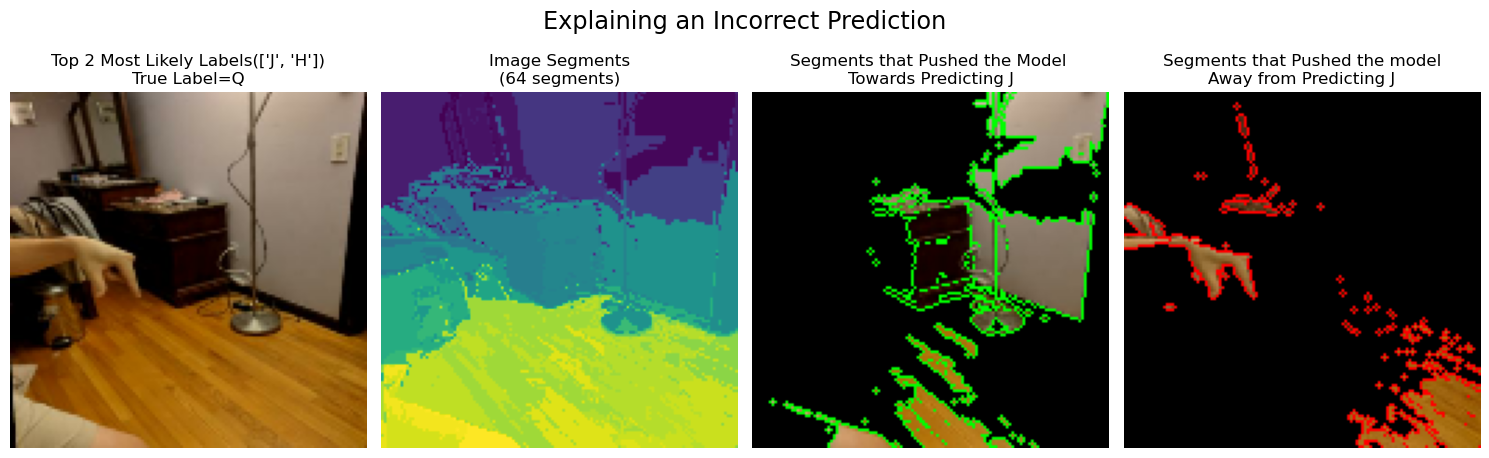

In [40]:
i_incorrect = 1

fig_fpath = FPATHS['images']['lime-incorrect-bad-image_png']
md_fpath = FPATHS['images']['lime-incorrect-bad-image_md']

fig = plot_comparison(BEST_MODEL, X_test_incorrect, y_test_incorrect, i_incorrect, label_lookup,
                      suptitle='Explaining an Incorrect Prediction')

fig.savefig(fig_fpath, dpi=300, transparent=False, bbox_inches='tight')

In [41]:
explanation_incorrect_bad_img ="""#### LIME Explanation for an Incorrectly Classified Image (Image Quality)

[IMG]


Here we can see that the model was able was confused by the image itself.
It seems to have mistaken the wood flooring for human fingers, thus preventing it from identifying the letter correctly.
Images like this should either be removed from the dataset or, ideally, augmented with an appropriate amount of data augmentaion.
If this task was converted to include object recognition, the model may have been able to classify it correctly.

This also underscores the need for quality, high-resolution training data for the best results.
"""


final_explanation_incorrect_bad_img = explanation_incorrect_bad_img.replace("[IMG]",f'<img src="{fig_fpath}">')
with open(md_fpath,'w') as f:
    f.write(final_explanation_incorrect_bad_img)

display(Markdown(final_explanation_incorrect_bad_img))

#### LIME Explanation for an Incorrectly Classified Image (Image Quality)

<img src="images/lime-explain-incorrect-bad-img.png">


Here we can see that the model was able was confused by the image itself.
It seems to have mistaken the wood flooring for human fingers, thus preventing it from identifying the letter correctly.
Images like this should either be removed from the dataset or, ideally, augmented with an appropriate amount of data augmentaion.
If this task was converted to include object recognition, the model may have been able to classify it correctly.

This also underscores the need for quality, high-resolution training data for the best results.


#### Incorrect - Sign Confusion

In [42]:
# pd.set_option('display.min_rows')
incorrect_df =pd.DataFrame({"True Label": y_test_incorrect,
              "Pred Label": y_hat_test_incorrect})
incorrect_df = incorrect_df.map(lambda x: label_lookup[x])
incorrect_df

,True Label,Pred Label
0,D,I
1,Q,J
2,V,I
3,U,Z
4,I,S
...,...,...
56,F,V
57,F,P
58,E,D
59,L,D


In [43]:
# string table for chatbot questions
str_df = incorrect_df.to_markdown()
# str_df

In [44]:
incorrect_df = incorrect_df.sort_values("True Label")
incorrect_df.head(10)

,True Label,Pred Label
54,A,M
36,B,F
22,B,I
14,C,F
28,D,I
41,D,F
44,D,L
9,D,I
0,D,I
51,E,S


In [45]:
incorrect_df['Mistaken For'] = incorrect_df['True Label'] +' for ' + incorrect_df['Pred Label']
most_confused = incorrect_df["Mistaken For"].value_counts().head()
most_confused

Mistaken For
G for H    4
D for I    3
E for S    2
Q for J    2
N for M    2
Name: count, dtype: int64

In [46]:
most_confused_index = incorrect_df[incorrect_df['Mistaken For'].isin(most_confused.index)].reset_index(drop=False)
most_confused_index

,index,True Label,Pred Label,Mistaken For
0,28,D,I,D for I
1,9,D,I,D for I
2,0,D,I,D for I
3,51,E,S,E for S
4,37,E,S,E for S
5,32,G,H,G for H
6,13,G,H,G for H
7,15,G,H,G for H
8,45,G,H,G for H
9,39,N,M,N for M


  0%|          | 0/1000 [00:00<?, ?it/s]

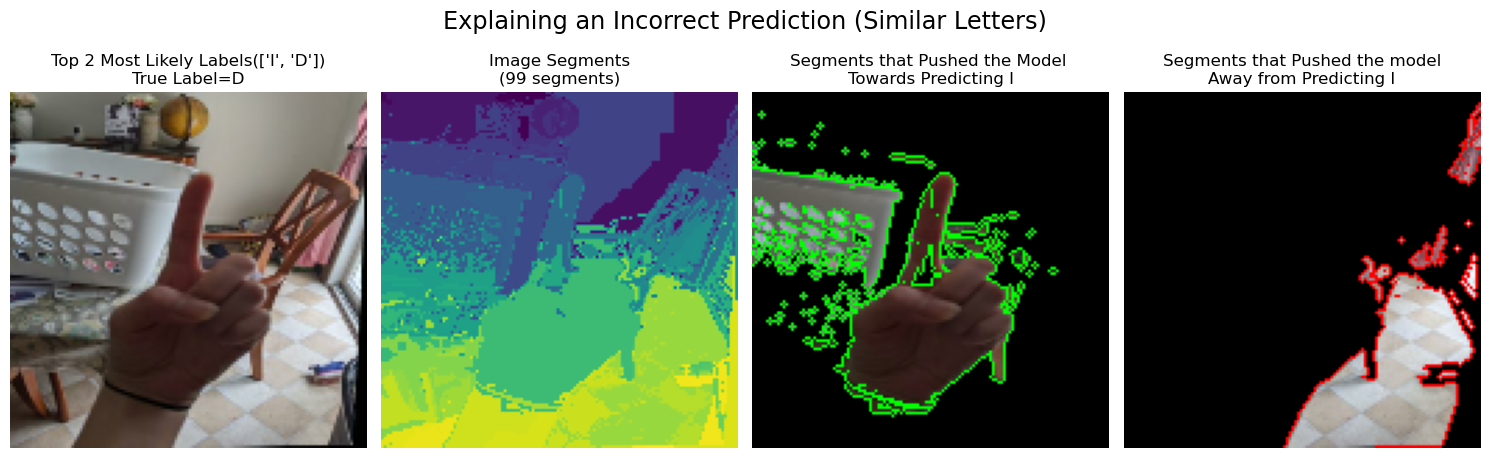

In [47]:
i_incorrect_conf = 9

fig_fpath = FPATHS['images']['lime-incorrect_png']
md_fpath = FPATHS['images']['lime-incorrect_md']


fig = plot_comparison(BEST_MODEL, X_test_incorrect, y_test_incorrect, i_incorrect_conf, label_lookup,
                      suptitle='Explaining an Incorrect Prediction (Similar Letters)')

fig.savefig(fig_fpath, dpi=300, transparent=False, bbox_inches='tight')

In [48]:
explaination_incorrect_confused = """#### LIME Explanation for Incorrect 
Here we can see a D that was mistaken for an I. This is an understandable mistake, as the two letters have strong similarities.

[IMG] 

- Key Similarities:
    - Single Extended Finger: Both D and I involve extending a single finger straight up. In D, it’s the index finger, while in I, it’s the pinky finger. This similarity can easily confuse a computer vision model, especially if the finger is not clearly visible due to angle or occlusion.
    - Curled Fingers: The rest of the fingers are curled or touching the thumb in both signs, forming a rounded shape that can look quite similar from certain angles.
     - Hand Orientation: Both letters are presented with the palm facing outward or slightly to the side, making it harder for the model to rely on palm orientation as a distinguishing feature.
- Key Differences:
     - Finger Extended: The primary difference lies in which finger is extended. The index finger for D and the pinky finger for I. The model needs to be trained to focus on which specific finger is extended.
    - Hand Shape: For D, the remaining fingers form a rounded base with the thumb, while for I, the remaining fingers form a fist. This difference in hand shape can be subtle and requires high-resolution images and careful feature extraction to capture effectively.
    - Thumb Position: In D, the thumb is actively touching the curved fingers, forming a distinct circle, while in I, the thumb is less prominent and rests over the curled fingers.
""" 
# display(Markdown(explaination_incorrect_confused))


final_explanation_incorrect_confused = explaination_incorrect_confused.replace("[IMG]",f'<img src="{fig_fpath}">')
with open(md_fpath,'w') as f:
    f.write(final_explanation_incorrect_confused)

display(Markdown(final_explanation_incorrect_confused))

#### LIME Explanation for Incorrect 
Here we can see a D that was mistaken for an I. This is an understandable mistake, as the two letters have strong similarities.

<img src="images/image-explain-incorrect.png"> 

- Key Similarities:
    - Single Extended Finger: Both D and I involve extending a single finger straight up. In D, it’s the index finger, while in I, it’s the pinky finger. This similarity can easily confuse a computer vision model, especially if the finger is not clearly visible due to angle or occlusion.
    - Curled Fingers: The rest of the fingers are curled or touching the thumb in both signs, forming a rounded shape that can look quite similar from certain angles.
     - Hand Orientation: Both letters are presented with the palm facing outward or slightly to the side, making it harder for the model to rely on palm orientation as a distinguishing feature.
- Key Differences:
     - Finger Extended: The primary difference lies in which finger is extended. The index finger for D and the pinky finger for I. The model needs to be trained to focus on which specific finger is extended.
    - Hand Shape: For D, the remaining fingers form a rounded base with the thumb, while for I, the remaining fingers form a fist. This difference in hand shape can be subtle and requires high-resolution images and careful feature extraction to capture effectively.
    - Thumb Position: In D, the thumb is actively touching the curved fingers, forming a distinct circle, while in I, the thumb is less prominent and rests over the curled fingers.


In [49]:
# explanation_g_h = """
# - G -> H:

# Similarities and Challenges:
# Horizontal Extended Fingers: Both G and H involve horizontally extended fingers. G has one finger (index) and the thumb extended, while H has two fingers (index and middle) extended. This similarity can lead to confusion, especially if the fingers are not clearly visible.
# Curled Remaining Fingers: In both signs, the remaining fingers are curled into the palm, making the hand shape look similar from certain angles.
# Hand Orientation: Both letters have the fingers extended horizontally, with the palm facing inward (G) or down/slightly inward (H), making it challenging for the model to use palm orientation as a distinguishing feature.
# Key Differences:
# Number of Extended Fingers: The main difference is the number of extended fingers. G has the index finger and thumb extended, while H has the index and middle fingers extended.
# Thumb Position: In G, the thumb is prominently extended parallel to the index finger, whereas in H, the thumb is curled into the palm.
# Hand Orientation: Although both have horizontal extensions, G’s palm faces inward, showing the side of the hand, while H’s palm faces down or slightly inward, making the fingers' alignment more visible from the top.

# """

# Combine Explanations

In [50]:
FPATHS['readme']

{'results_table_md': 'modeling/results_table.md',
 'Part01-intro_md': 'config/readme_part1_intro.md',
 'Part02-model': 'config/readme_part2_results.md',
 'Part03-explain': 'config/readme_part3_lime_explanations.md',
 'Part04-conclusion': 'config/readme_part4_conclusion.md'}

In [51]:
for k,v in FPATHS['images'].items():
    if k.endswith('_md') and 'table' not in k:
        print(k)

lime-correct_md
lime-incorrect_md
lime-incorrect-bad-image_md


In [52]:
## Combining Markdown explanations for README
combined = [
"""### Explaining Model Predictions with LIME

- To better understand how the model was correctly or incorrectly classifying an image, we leveraged LIME's Image Explainer.
- LIME's image explainer creates its own model to explain a model's prediction for a single image at a time. By inspecting the images the model is having difficulty with, we can get insights into how to change our modeling process/architecture.
"""
]

keys_in_order = ['lime-correct_md','lime-incorrect-bad-image_md','lime-incorrect_md']


for k in keys_in_order:
    # if k.endswith('_md') and 'table' not in k:
    v = FPATHS['images'][k]
    with open(v) as f:
        combined.append(f.read())

combined.append("""### LIME Explanations - Implications for Modeling

To increase the ease of training of a model to better distinguish between similar letters, we should consider the following:

- Use High-Resolution images to capture the fine details of finger positioning.
    - This could be as simple as increasing the height and width of the input images, or may involve acquiring higher quality training data.
- Apply Data Augmentation techniques to ensure the model sees these letters from various angles and under different lighting conditions.
    - Due to the nature of the ASL alphabet and the expected orientation of the hand, data augmentation should be applied much more carefully than with other tasks where orientation is more variable.
- Feature Extraction: Focus on extracting features related to the number of extended fingers and the specific shape and orientation of the thumb.
    - Investigate the feature maps extracted from each convolution layer to better optimize feature extraction.
    
- More robust training using more examples of letters that are very similar.
""")

combined_markdown = "\n".join(combined)
display(Markdown(combined_markdown))

### Explaining Model Predictions with LIME

- To better understand how the model was correctly or incorrectly classifying an image, we leveraged LIME's Image Explainer.
- LIME's image explainer creates its own model to explain a model's prediction for a single image at a time. By inspecting the images the model is having difficulty with, we can get insights into how to change our modeling process/architecture.

#### LIME Explanation for Correctly Classified Image

<img src="images/lime-explain-correct.png">

Here we can see that the model was able to identify the letter O using the palm and thumb. The model used the crevice betwen the pinky and ring finges to differeniate between O and F.

The letters O and F in ASL are indeed similar, as both involve the fingers forming a loop. However, they have distinct differences that can be critical for accurate classification.


- Key Similarities:
    - Both letters involve forming a loop with the fingers.
    - Both have a circular shape as part of the sign.
- Key Differences:
    - In the letter O, all fingers and the thumb touch to form the circle, while in the letter F, only the thumb and index finger touch.
    - The remaining fingers in the letter F are extended, whereas in the letter O, they are curved and relaxed.
#### LIME Explanation for an Incorrectly Classified Image (Image Quality)

<img src="images/lime-explain-incorrect-bad-img.png">


Here we can see that the model was able was confused by the image itself.
It seems to have mistaken the wood flooring for human fingers, thus preventing it from identifying the letter correctly.
Images like this should either be removed from the dataset or, ideally, augmented with an appropriate amount of data augmentaion.
If this task was converted to include object recognition, the model may have been able to classify it correctly.

This also underscores the need for quality, high-resolution training data for the best results.

#### LIME Explanation for Incorrect 
Here we can see a D that was mistaken for an I. This is an understandable mistake, as the two letters have strong similarities.

<img src="images/image-explain-incorrect.png"> 

- Key Similarities:
    - Single Extended Finger: Both D and I involve extending a single finger straight up. In D, it’s the index finger, while in I, it’s the pinky finger. This similarity can easily confuse a computer vision model, especially if the finger is not clearly visible due to angle or occlusion.
    - Curled Fingers: The rest of the fingers are curled or touching the thumb in both signs, forming a rounded shape that can look quite similar from certain angles.
     - Hand Orientation: Both letters are presented with the palm facing outward or slightly to the side, making it harder for the model to rely on palm orientation as a distinguishing feature.
- Key Differences:
     - Finger Extended: The primary difference lies in which finger is extended. The index finger for D and the pinky finger for I. The model needs to be trained to focus on which specific finger is extended.
    - Hand Shape: For D, the remaining fingers form a rounded base with the thumb, while for I, the remaining fingers form a fist. This difference in hand shape can be subtle and requires high-resolution images and careful feature extraction to capture effectively.
    - Thumb Position: In D, the thumb is actively touching the curved fingers, forming a distinct circle, while in I, the thumb is less prominent and rests over the curled fingers.

### LIME Explanations - Implications for Modeling

To increase the ease of training of a model to better distinguish between similar letters, we should consider the following:

- Use High-Resolution images to capture the fine details of finger positioning.
    - This could be as simple as increasing the height and width of the input images, or may involve acquiring higher quality training data.
- Apply Data Augmentation techniques to ensure the model sees these letters from various angles and under different lighting conditions.
    - Due to the nature of the ASL alphabet and the expected orientation of the hand, data augmentation should be applied much more carefully than with other tasks where orientation is more variable.
- Feature Extraction: Focus on extracting features related to the number of extended fingers and the specific shape and orientation of the thumb.
    - Investigate the feature maps extracted from each convolution layer to better optimize feature extraction.
    
- More robust training using more examples of letters that are very similar.


In [62]:
combined_md_fpath = FPATHS['readme']['Part03-explain'] #"config/readme-lime-explanations.md"
with open(combined_md_fpath,'w') as f:
    f.write(combined_markdown)

# Future Work

## Labels Most Often Confused [via Confusion Matrix]

In [54]:
from sklearn.metrics import confusion_matrix
pd.set_option("display.max_columns",50)
conf_matrix = confusion_matrix(y_test, y_hat_test, normalize='true')
conf_matrix_df = pd.DataFrame(conf_matrix, columns=label_lookup.values(),
             index=label_lookup.values()).round(2)

conf_matrix_df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,0.86,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
B,0.00,0.6,0.00,0.00,0.00,0.20,0.0,0.0,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
C,0.00,0.0,0.88,0.00,0.00,0.12,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
D,0.00,0.0,0.00,0.58,0.00,0.08,0.0,0.0,0.25,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
E,0.00,0.0,0.00,0.17,0.33,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.0,0.00,0.33,0.00,0.00,0.00,0.0,0.00,0.00,0.00
F,0.00,0.0,0.00,0.14,0.00,0.43,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.0,0.00,0.00,0.00,0.14,0.14,0.0,0.00,0.00,0.00
G,0.00,0.0,0.00,0.00,0.00,0.00,0.6,0.4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
H,0.00,0.0,0.00,0.00,0.00,0.00,0.0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
I,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.11,0.00,0.00,0.00,0.0,0.00,0.11,0.00
J,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.06


In [55]:
conf_matrix_df.style.background_gradient(axis=None)

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,0.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B,0.000000,0.600000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C,0.000000,0.000000,0.880000,0.000000,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
D,0.000000,0.000000,0.000000,0.580000,0.000000,0.080000,0.000000,0.000000,0.250000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E,0.000000,0.000000,0.000000,0.170000,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F,0.000000,0.000000,0.000000,0.140000,0.000000,0.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.140000,0.140000,0.000000,0.000000,0.000000,0.000000
G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000
J,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000


In [56]:
df_stacked = conf_matrix_df.stack().reset_index()
df_stacked = df_stacked.rename({"level_0":'True Label','level_1':'Pred Label',
                               0:"% of True Label Confused"}, axis=1)
df_stacked

,True Label,Pred Label,% of True Label Confused
0,A,A,0.86
1,A,B,0.00
2,A,C,0.00
3,A,D,0.00
4,A,E,0.00
...,...,...,...
671,Z,V,0.00
672,Z,W,0.00
673,Z,X,0.00
674,Z,Y,0.00


In [57]:
df_stacked['Is-Identity'] = df_stacked['True Label'] == df_stacked['Pred Label']

df_stacked=  df_stacked[ df_stacked['Is-Identity']==False]
df_stacked = df_stacked.drop(columns='Is-Identity')
df_stacked

,True Label,Pred Label,% of True Label Confused
1,A,B,0.0
2,A,C,0.0
3,A,D,0.0
4,A,E,0.0
5,A,F,0.0
...,...,...,...
670,Z,U,0.0
671,Z,V,0.0
672,Z,W,0.0
673,Z,X,0.0


In [58]:
confused_preds = df_stacked[df_stacked['% of True Label Confused']>0]
confused_preds = confused_preds.set_index(["True Label","Pred Label"]).sort_index()
confused_preds.style.bar()

In [59]:
confused_preds = confused_preds.sort_values("% of True Label Confused", ascending=False)#).reset_index(drop=True)
confused_preds.style.bar()

,,% of True Label Confused
True Label,Pred Label,
G,H,0.400000
E,S,0.330000
D,I,0.250000
W,V,0.200000
B,I,0.200000
Q,J,0.200000
B,F,0.200000
N,M,0.170000
E,D,0.170000


In [60]:
confused_preds.head()

,,% of True Label Confused
True Label,Pred Label,
G,H,0.40
E,S,0.33
D,I,0.25
W,V,0.20
B,I,0.20


In [61]:
# df_stacked['Index-Column'] = df_stacked['index'] + '-' + df_stacked['column']
# df_stacked